In [7]:
import sys

!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install dagshub
!{sys.executable} -m pip install mlflow


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
# set up dagshub for mlflow tracking
import dagshub
dagshub.init(repo_owner='JonaKoenemann', repo_name='machine_failure_classification', mlflow=True)

Initialized MLflow to track repo "JonaKoenemann/machine_failure_classification"

Repository JonaKoenemann/machine_failure_classification initialized!

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Data preparation

In [12]:
data_path = "../../data/predictive_maintenance.csv"

In [13]:
df = pd.read_csv(data_path)

In [14]:
# Split for features (X) und labels (y)
X = df.drop(columns=["Product ID", "Type", "Target", "Failure Type"])  # select Features 
y = df["Failure Type"]

# Split for test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and test

In [15]:
mlflow.set_experiment("random_forest")

2024/04/29 19:25:37 INFO mlflow.tracking.fluent: Experiment with name 'random_forest' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/7e363152a31943cbba0aad0bd7a50713', creation_time=1714411539343, experiment_id='0', last_update_time=1714411539343, lifecycle_stage='active', name='random_forest', tags={}>

In [16]:
mlflow.sklearn.autolog()

with mlflow.start_run():

    start_time = time.time()

    # training
    rf_classifier = RandomForestClassifier(n_estimators=150, random_state=42)
    rf_classifier.fit(X_train, y_train)

    mlflow.log_metric('training_time', time.time()-start_time)

    # predicition
    y_pred = rf_classifier.predict(X_test)

    # evaluation
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    mlflow.log_metric('accuracy', accuracy)
    mlflow.end_run()

2024/04/29 19:25:41 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\jkoenemann\GitHub\machine_failure_classification\venv\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2024/04/29 19:25:41 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\jkoenemann\GitHub\machine_failure_classification\venv\Lib\site-packages\mlflow\types\utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these colum

Accuracy: 0.9815


# Evaluation

In [17]:
print("Classification Report:")
report = classification_report(y_test, y_pred)
print(report)

Classification Report:
                          precision    recall  f1-score   support

Heat Dissipation Failure       0.81      0.87      0.84        15
              No Failure       0.99      1.00      0.99      1935
      Overstrain Failure       0.78      0.54      0.64        13
           Power Failure       0.83      0.75      0.79        20
         Random Failures       0.00      0.00      0.00         6
       Tool Wear Failure       0.00      0.00      0.00        11

                accuracy                           0.98      2000
               macro avg       0.57      0.53      0.54      2000
            weighted avg       0.97      0.98      0.98      2000



c:\Users\jkoenemann\GitHub\machine_failure_classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jkoenemann\GitHub\machine_failure_classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jkoenemann\GitHub\machine_failure_classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [18]:
# error_names = list(df["Failure Type"].unique())
error_names = [
 'Heat Failure',
 'No Failure',
 'Overstrain Failure',
 'Power Failure',
 'Random Failure',
 'Tool wear Failure'] # get names of errors in correct order for confusion matrix

In [19]:
for error in error_names:
    print(f"Sum {error}: {df.loc[df['Failure Type'] == error].shape[0]}")

Sum Heat Failure: 0
Sum No Failure: 9652
Sum Overstrain Failure: 78
Sum Power Failure: 95
Sum Random Failure: 0
Sum Tool wear Failure: 0


## Confusion matrix

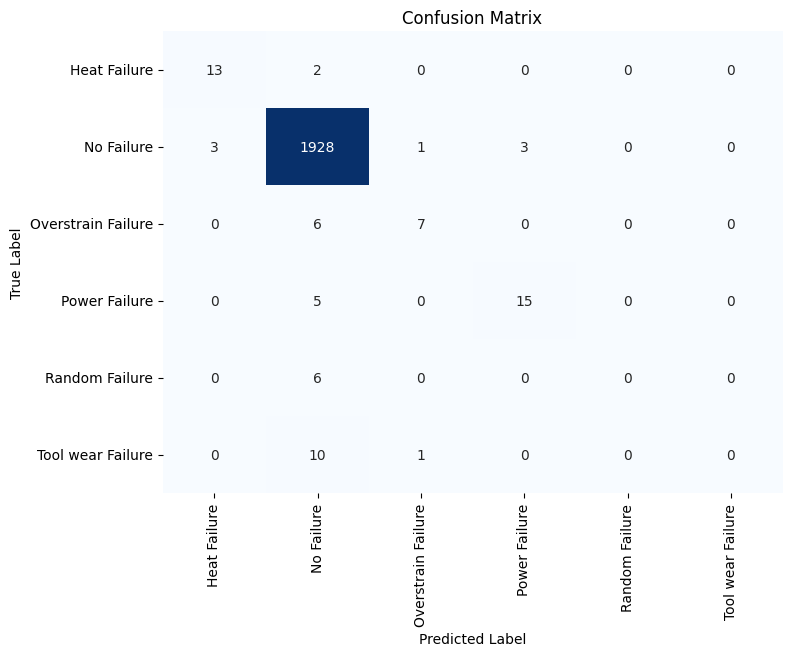

In [20]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=error_names, yticklabels=error_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## Normalized confusion matrix

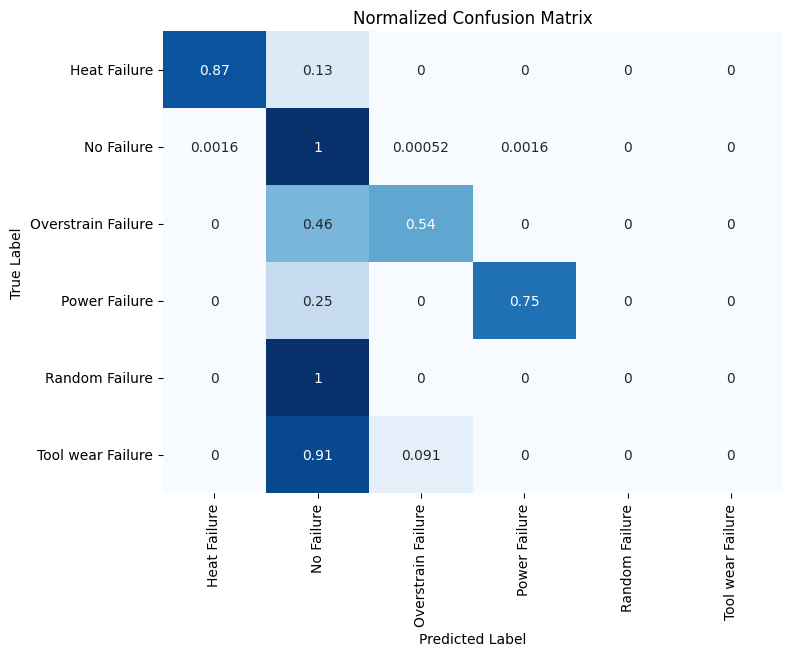

In [21]:
conf_matrix_normalized = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, cmap="Blues", cbar=False, xticklabels=error_names, yticklabels=error_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.show()
